# Using dask to deconvolve large arrays in tiles

Try using dask to deconvolve large volumes tile by tile.

**Possible applications:**

* whole volume too large for GPU memory -> split into tiles and run 1 worker
* run on multi-core CPU -> process tiles in parallel to speed up processing

**Requires**
`dask` (install via pip or conda-forge)

_Volker_ `dot` _Hilsenstein_ `@` _Monash_ `dot` _edu, April, 2019
License: BSD-3

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from flowdec.nb import utils as nbutils 
from flowdec import data as fd_data
from scipy import ndimage
import dask
import dask.array as da
import tensorflow as tf
from flowdec.restoration import RichardsonLucyDeconvolver

In [2]:
# Load volume downsampled to 25%
acq = fd_data.neuron_25pct()
acq.shape()

{'data': (50, 256, 256), 'kernel': None, 'actual': None}

In [3]:
# create a gaussian kernel
kernel = np.zeros_like(acq.data)
for offset in [0, 1]:
    kernel[tuple((np.array(kernel.shape) - offset) // 2)] = 1
kernel = ndimage.gaussian_filter(kernel, sigma=1.)

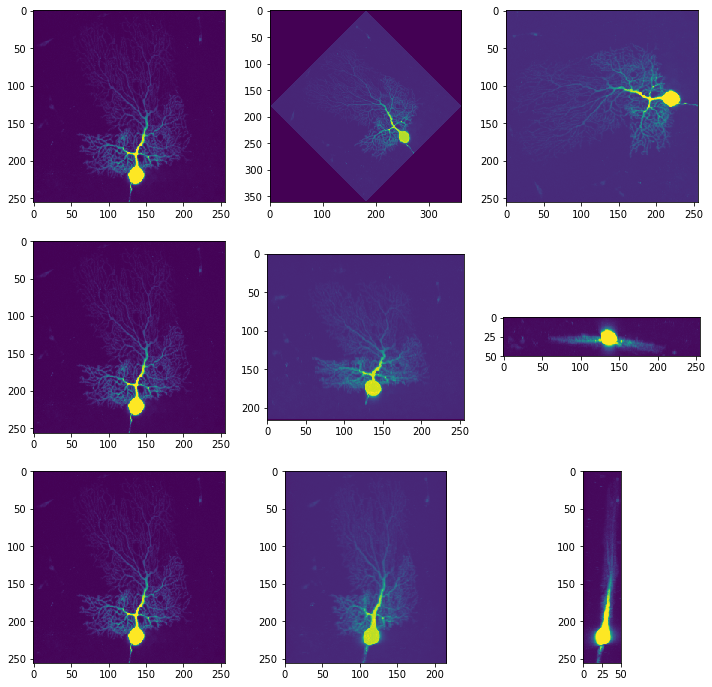

In [4]:
nbutils.plot_rotations(acq.data)

### Code snippet for cropping to a given size around the centre
was lazy and just googled for one...
Took the  2nd answer here: https://stackoverflow.com/questions/39382412/crop-center-portion-of-a-numpy-image

In [5]:
import operator
def cropND(img, bounding):
    start = tuple(map(lambda a, da: a//2-da//2, img.shape, bounding))
    end = tuple(map(operator.add, start, bounding))
    slices = tuple(map(slice, start, end))
    return img[slices]

### prepare for chunked deconvolution

`chunk_size` should fit evenly into the original volume, otherwise dask will 
create differently sized chunks at the end with the remainder. This would
cause problems with pad_sizes and kernel sizes. (try with `chunk_size=(48,64,64)` and you will see why).

Make sure to set `pad_min` to something that is at least the size of the support of your PSF.


In [6]:
chunk_size = (50,64,64)
# chunked dask array
arr = da.from_array(acq.data, chunks=chunk_size)
# kernel cropped to chunk size
cropped_kernel = cropND(kernel, chunk_size)
algo = RichardsonLucyDeconvolver(acq.data.ndim, pad_mode="2357", pad_min=(6,6,6))

def deconv(chunk):
    # note that algo and cropped_kernel are from global scope ... ugly
    print("chunk shape", chunk.shape)
    tmp = algo.initialize().run(fd_data.Acquisition(data=chunk, kernel=cropped_kernel), 5, session_config=tf.ConfigProto(device_count={'GPU': 0}))
    return tmp.data 

### Execute the chunked deconvolution

* **Use one worker only** if the aim of the tiling is to save GPU memory (otherwise multiple workers will compete for the GPU memory).
* To actually run this on a GPU **remove `session_config=tf.ConfigProto(device_count={'GPU': 0})` above** (this was just for testing on my laptop without GPU).

### Option 1:... use `map_blocks` for non-overlapping tiles

In [9]:
result_blocks = arr.map_blocks(deconv,dtype='float32').compute(num_workers=1)

chunk shape (50, 64, 64)
chunk shape (50, 64, 64)
chunk shape (50, 64, 64)
chunk shape (50, 64, 64)
chunk shape (50, 64, 64)
chunk shape (50, 64, 64)
chunk shape (50, 64, 64)
chunk shape (50, 64, 64)
chunk shape (50, 64, 64)
chunk shape (50, 64, 64)
chunk shape (50, 64, 64)
chunk shape (50, 64, 64)
chunk shape (50, 64, 64)
chunk shape (50, 64, 64)
chunk shape (50, 64, 64)
chunk shape (50, 64, 64)


### Option 2:... use `map_overlap` for overlapping tiles. This should reduce artefacts at tile boundaries.

In [10]:
result_overlap = arr.map_overlap(deconv,depth=(6,6,6), boundary='reflect', dtype='float32').compute(num_workers=1)

chunk shape (62, 76, 76)
chunk shape (62, 76, 76)
chunk shape (62, 76, 76)
chunk shape (62, 76, 76)
chunk shape (62, 76, 76)
chunk shape (62, 76, 76)
chunk shape (62, 76, 76)
chunk shape (62, 76, 76)
chunk shape (62, 76, 76)
chunk shape (62, 76, 76)
chunk shape (62, 76, 76)
chunk shape (62, 76, 76)
chunk shape (62, 76, 76)
chunk shape (62, 76, 76)
chunk shape (62, 76, 76)
chunk shape (62, 76, 76)


Plot the same rotations for the resulting deconvolved volume:

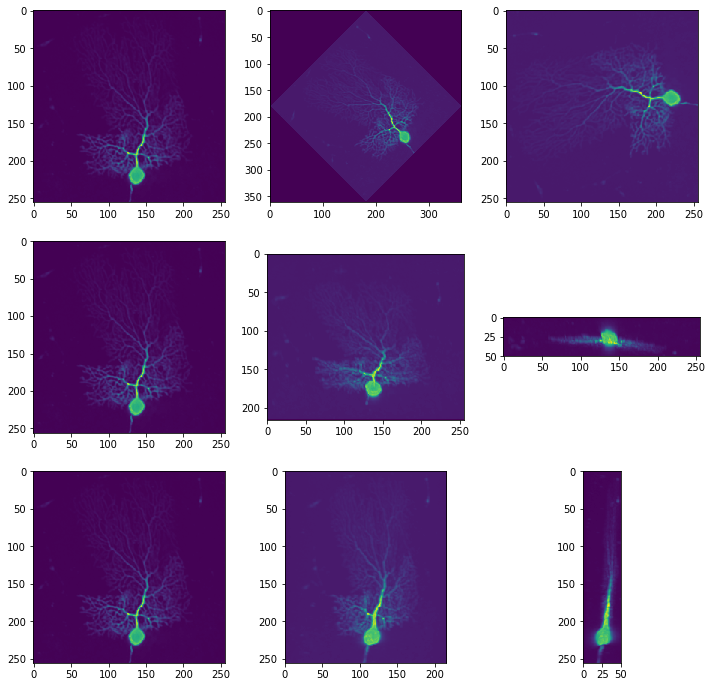

In [11]:
nbutils.plot_rotations(result_overlap)

### Inspect absolute difference between overlapping and non-overlapping tiles

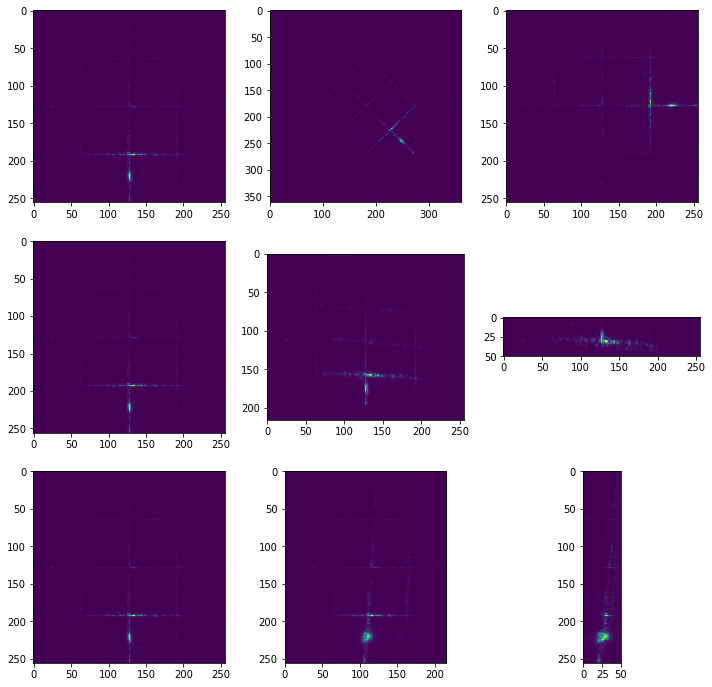

In [12]:
nbutils.plot_rotations(np.abs(result_overlap-result_blocks))

### On a CPU with multiple cores, one can also increase the number of workers to speed things up 

comparison between 1 and 4 workers

In [9]:
%%timeit -n 1 -r 1
result = arr.map_blocks(deconv, dtype='float32').compute(num_workers=1)

chunk shape (50, 64, 64)
chunk shape (50, 64, 64)
chunk shape (50, 64, 64)
chunk shape (50, 64, 64)
chunk shape (50, 64, 64)
chunk shape (50, 64, 64)
chunk shape (50, 64, 64)
chunk shape (50, 64, 64)
chunk shape (50, 64, 64)
chunk shape (50, 64, 64)
chunk shape (50, 64, 64)
chunk shape (50, 64, 64)
chunk shape (50, 64, 64)
chunk shape (50, 64, 64)
chunk shape (50, 64, 64)
chunk shape (50, 64, 64)
59.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [10]:
%%timeit -n 1 -r 1
result = arr.map_blocks(deconv, dtype='float32').compute(num_workers=4)

chunk shape (50, 64, 64)
chunk shape (50, 64, 64)
chunk shape (50, 64, 64)
chunk shape (50, 64, 64)
chunk shape (50, 64, 64)
chunk shape (50, 64, 64)
chunk shape (50, 64, 64)
chunk shape (50, 64, 64)
chunk shape (50, 64, 64)
chunk shape (50, 64, 64)
chunk shape (50, 64, 64)
chunk shape (50, 64, 64)
chunk shape (50, 64, 64)
chunk shape chunk shape (50, 64, 64)(50, 64, 64)

chunk shape (50, 64, 64)
28.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
